<a href="https://colab.research.google.com/github/deepnoid/education/blob/master/1.%20Python%20Basic/Lung_segmentation_with_sample_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/deepnoid/education.git
!pip install SimpleITK

Cloning into 'education'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 858 (delta 6), reused 0 (delta 0), pack-reused 838
Receiving objects: 100% (858/858), 61.93 MiB | 10.65 MiB/s, done.
Resolving deltas: 100% (107/107), done.
     |████████████████████████████████| 42.5MB 71kB/s 


# 라이브러리 불러오기

In [0]:
import numpy as np
import os
import copy
import SimpleITK as sitk
from glob import glob
from matplotlib import pyplot as plt

# 함수 코드

In [0]:
#@title
def make_sample(sample):
    print('< make_sample >')
    show_image(sample)
    return copy.deepcopy(sample)

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

def make_mask1(sample, min_val, max_val):
    sample[np.logical_or(sample<min_val, max_val<sample)] = 0
    sample[np.logical_and(min_val<=sample, sample<=max_val)] = 1
    print('< make_mask1 >')    
    show_image(sample)
    return sample

def make_mask2(img, min_val=-1300, max_val=-450):
    img = sitk.GetImageFromArray(img)
    width, height = img.GetSize()

    gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
    gaussian.SetSigma(1)
    img = gaussian.Execute(img)
    seed_x1 = int(width*16/64)
    seed_x2 = int(width*46/64)
    seed_y = int(height*30/64)
    
    right_lobe_seed1 = (seed_x1, seed_y)
    right_lobe_seed2 = (seed_x1, seed_y)
    right_lobe_seed3 = (seed_x1, seed_y)
    left_lobe_seed1 = (seed_x2, seed_y)
    left_lobe_seed2 = (seed_x2, seed_y)
    left_lobe_seed3 = (seed_x2, seed_y)
    
    seed = [right_lobe_seed1, left_lobe_seed1, right_lobe_seed2, left_lobe_seed2, right_lobe_seed3, left_lobe_seed3]
    mask = sitk.ConnectedThreshold(img, seedList=seed, lower=min_val, upper=max_val)
    mask_arr = sitk.GetArrayFromImage(mask)
    print('< make_mask2 >')    
    show_image(mask_arr)
    return mask_arr

def slice_image1(img, Y_MIN, Y_MAX, X_MIN, X_MAX):
    sliced_img = img[Y_MIN:Y_MAX, X_MIN:X_MAX]
    extendbox = np.array([[Y_MIN, Y_MAX], [X_MIN, X_MAX]])
    print('< slice_image1 >')    
    show_image(sliced_img)
    return sliced_img, extendbox

def slice_image2(img):
    newshape = img.shape
    xx, yy = np.where(img)
    box = np.array([[np.min(xx), np.max(xx)], [np.min(yy), np.max(yy)]])
    margin = 5
    extendbox = np.vstack(
        [np.max([[0, 0], box[:, 0] - margin], 0), np.min([newshape, box[:, 1] + 2 * margin], axis=0).T]).T
    extendbox = extendbox.astype('int')
    sliced_img = img[
        extendbox[0, 0]:extendbox[0, 1],
        extendbox[1, 0]:extendbox[1, 1]
    ]
    print('< slice_image2 >')    
    show_image(sliced_img)
    return sliced_img, extendbox

def make_smaller_image(img, erosion=3):
    img = sitk.GetImageFromArray(img)
    eroded_img = sitk.BinaryErode(img, erosion)
    eroded_img = sitk.GetArrayFromImage(eroded_img)
    print('< make_smaller_image >')    
    show_image(eroded_img)
    return eroded_img

def make_larger_image(img, dilation=7):
    img = sitk.GetImageFromArray(img)
    dilated_img = sitk.BinaryDilate(img, dilation)
    dilated_img = sitk.GetArrayFromImage(dilated_img)
    print('< make_larger_image >')    
    show_image(dilated_img)
    return dilated_img

def fill_hole(img, filter_size=7):
    closing = sitk.BinaryMorphologicalClosingImageFilter()
    closing.SetForegroundValue(1)
    closing.SetKernelRadius(filter_size)
    img = sitk.GetImageFromArray(img)
    img = closing.Execute(img)
    img = sitk.GetArrayFromImage(img)
    print('< fill_hole >')
    show_image(img)
    return img

def show_final_image(original_img, img, extendbox):
    newshape = img.shape
    xx, yy = np.where(img)
    box = np.array([[np.min(xx), np.max(xx)], [np.min(yy), np.max(yy)]])
    margin = 5
    sliced_img = original_img[
        extendbox[0, 0]:extendbox[0, 1],
        extendbox[1, 0]:extendbox[1, 1]
    ]
    masked_img = sliced_img * img
    print('< show_final_image >')    
    fig, ax = plt.subplots(1, 2, figsize=(10, 20))
    ax[0].imshow(original_img, cmap='gray')
    ax[1].imshow(masked_img, cmap='gray')
    plt.show() 

# 이미지 불러오기

In [0]:
base_path = r'./education/8. Dataset/lung_sample.npz'
lung_sample = np.load(base_path)
image_1 = lung_sample['sample1']
image_2 = lung_sample['sample2']
image_3 = lung_sample['sample3']

# 함수 모음 

#### 1. 이미지 출력 : show_image(image_xxx)
-- show_image(image_xxx)

#### 2. 샘플 이미지 만들기 : make_sample(sample1)  
-- sample = make_sample(image_xxx)  

#### 3. 폐 영역 마스크 만들기 1 : make_mask1(sample, MIN_VAL, MAX_VAL)
-- sample = make_mask1(sample, MIN_VAL, MAX_VAL)

#### 4. 폐 영역 마스크 만들기 2 : make_mask2(sample, MIN_VAL, MAX_VAL)
-- sample = make_mask2(sample, MIN_VAL, MAX_VAL)

#### 5. 이미지 범위 넓히기 : make_larger_image(sample, LARGER_RATE)
-- sample = make_larger_image(sample, LARGER_RATE)

#### 6. 이미지 범위 줄이기 : make_smaller_image(sample, SMALLER_RATE)
-- sample = make_smaller_image(sample, SMALLER_RATE)

#### 7. 구멍 메꾸기 : fill_hole(sample, FILL_SIZE)
-- sample = fill_hole(sample, FILL_SIZE)

#### 8. 이미지 자르기 1 : slice_image1(sample, Y_MIN, Y_MAX, X_MIN, X_MAX)
-- sample, box = slice_image1(sample, Y_MIN, Y_MAX, X_MIN, X_MAX)

#### 9. 이미지 자르기 2 : slice_image2(sample)
-- sample, box = slice_image2(sample)

#### 10. 최종 이미지 출력 : show_final_image(image_x, sample, box)
-- show_final_image(image_xxx, sample, box)

# 옵션값 모음

In [0]:
MIN_VAL = -1000  # 최소 밝기
MAX_VAL = -450   # 최대 밝기
FILL_SIZE = 7    # 구멍 메꾸는 정도(클수록 많이 메꿈)
LARGER_RATE = 7  # 이미지 범위 넓히는 정도(클수록 더 넓혀짐)
SMALLER_RATE = 7 # 이미지 범위 좁히는 정도(클수록 더 좁혀짐)
Y_MIN = 150
Y_MAX = 400
X_MIN = 90
X_MAX = 400

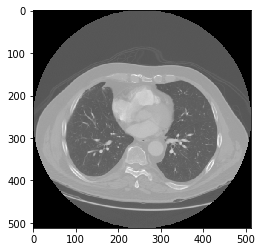

< make_sample >


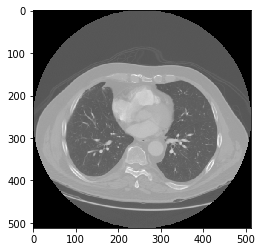

< make_mask2 >


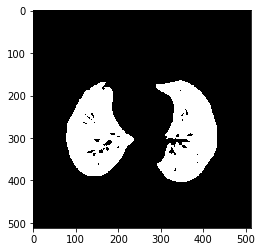

< make_larger_image >


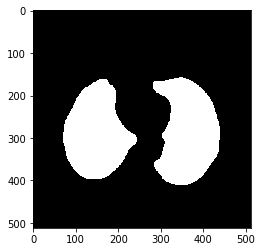

< make_smaller_image >


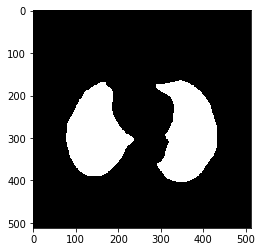

< fill_hole >


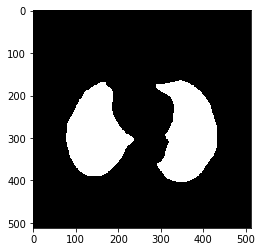

< slice_image2 >


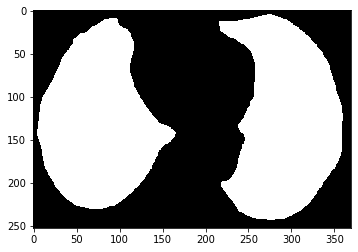

< show_final_image >


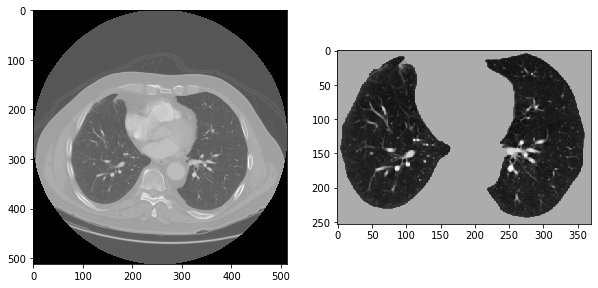

In [8]:
show_image(image_1)
sample = make_sample(image_1)
sample = make_mask2(sample, MIN_VAL, MAX_VAL)
sample = make_larger_image(sample, LARGER_RATE)
sample = make_smaller_image(sample, SMALLER_RATE)
sample = fill_hole(sample, FILL_SIZE)
sample, box = slice_image2(sample)
show_final_image(image_1, sample, box)